In [1]:
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, Dropout, Dense, Flatten, LSTM, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, save_model
from keras.utils import np_utils
from scipy.io import loadmat
import pickle
import argparse
import keras
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import sklearn.cross_validation as cv

Using TensorFlow backend.
P:\Anaconda2\envs\HORUS\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
mat_file_path = 'O:\\Data\\HORUS\\emnist-byclass.mat'
mat = loadmat(mat_file_path)

# Load char mapping
mapping = {kv[0]:kv[1:][0] for kv in mat['dataset'][0][0][2]}
pickle.dump(mapping, open('mapping.p', 'wb' ))

In [3]:
# Load training data
max_train = len(mat['dataset'][0][0][0][0][0][0])
training_images = mat['dataset'][0][0][0][0][0][0][:max_train]
training_labels = mat['dataset'][0][0][0][0][0][1][:max_train]

In [4]:
# confirm training population
max_train

697932

In [5]:
# Load testing data
max_test = len(mat['dataset'][0][0][1][0][0][0])
testing_images = mat['dataset'][0][0][1][0][0][0][:max_test]
testing_labels = mat['dataset'][0][0][1][0][0][1][:max_test]

In [6]:
# confirm testing population
max_test

116323

In [7]:
#ensure all images are 28x28 and are positioned correctly
def reshape(img):
    # Used to rotate images (for some reason they are transposed on read-in)
    img.shape = (28,28)
    img = img.T
    img = list(img)
    img = [item for sublist in img for item in sublist]
    return img

for i in range(len(training_images)):
    training_images[i] = reshape(training_images[i])
print('Training Resize Complete')

for i in range(len(testing_images)):
    testing_images[i] = reshape(testing_images[i])
print('Testing Resize Complete')

Training Resize Complete
Testing Resize Complete


In [8]:
# Extend the arrays to (None, 28, 28, 1)
training_images = training_images.reshape(training_images.shape[0], 28, 28, 1)
testing_images = testing_images.reshape(testing_images.shape[0], 28, 28, 1)

In [9]:
# Convert type to float32
training_images = training_images.astype('float32')
testing_images = testing_images.astype('float32')

In [10]:
# Normalize to prevent issues with model
training_images /= 255
testing_images /= 255

In [11]:
nb_classes = len(mapping)

In [12]:
# Initialize data
x_train = training_images
y_train = training_labels
x_test = testing_images
y_test = testing_labels

input_shape = (28, 28, 1)

In [13]:
# Hyperparameters
nb_filters = 32 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

model = Sequential()
model.add(Convolution2D(nb_filters,
                        kernel_size,
                        padding='valid',
                        input_shape=input_shape,
                        activation='relu'))
model.add(Convolution2D(nb_filters,
                        kernel_size,
                        activation='relu'))

model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [36]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

Train on 697932 samples, validate on 116323 samples
Epoch 1/100
697932/697932 [==============================] - 44s - loss: 0.3197 - acc: 0.8839 - val_loss: 0.3988 - val_acc: 0.8740
Epoch 2/100
697932/697932 [==============================] - 43s - loss: 0.3200 - acc: 0.8843 - val_loss: 0.3545 - val_acc: 0.8732
Epoch 3/100
697932/697932 [==============================] - 43s - loss: 0.3203 - acc: 0.8842 - val_loss: 0.3923 - val_acc: 0.8739
Epoch 4/100
697932/697932 [==============================] - 43s - loss: 0.3195 - acc: 0.8841 - val_loss: 0.3691 - val_acc: 0.8672
Epoch 5/100
697932/697932 [==============================] - 43s - loss: 0.3195 - acc: 0.8845 - val_loss: 0.3531 - val_acc: 0.8736
Epoch 6/100
697932/697932 [==============================] - 43s - loss: 0.3205 - acc: 0.8842 - val_loss: 0.3528 - val_acc: 0.8744
Epoch 7/100
697932/697932 [==============================] - 43s - loss: 0.3194 - acc: 0.8842 - val_loss: 0.3489 - val_acc: 0.8741
Epoch 8/100
697932/697932 [====

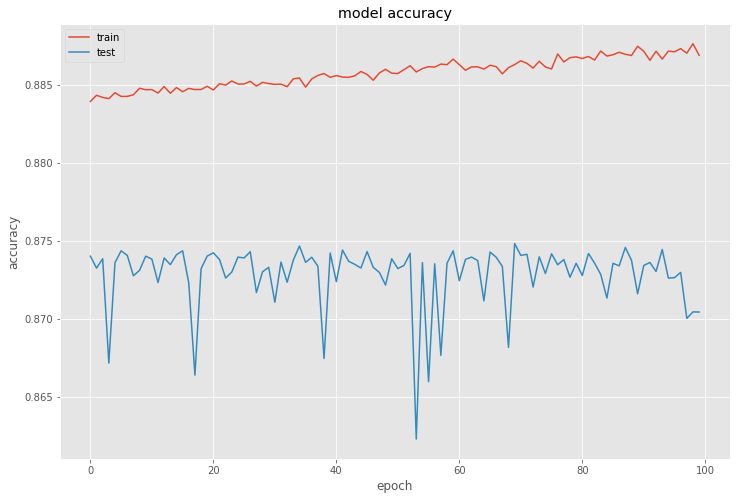

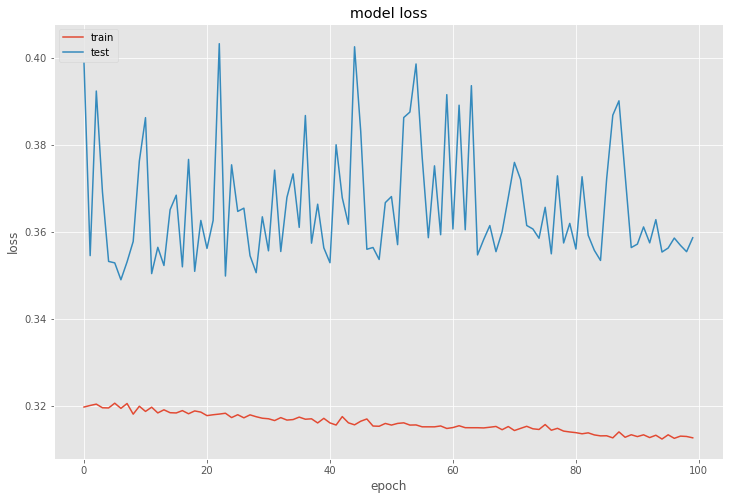

In [46]:
history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=None)
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.358586772516
Test accuracy: 0.870438348392


In [39]:
# Offload model to file
model_yaml = model.to_yaml()
with open("/model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
save_model(model, '/model.h5')